# Introduction to text analysis IX #

*Revision 2019*

### text clustering ###

The clustering of text is more properly a clustering of documents according to their similarity

In [1]:
import pickle
import string
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import numpy as np

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


In [5]:
from sklearn.datasets import fetch_20newsgroups

In [6]:
stops_it = stopwords.words('italian')
stops_en = stopwords.words('english')

translator = str.maketrans(' ', ' ', string.punctuation) ## remove the punctuation

**fetch the 20 newsgroups**

In [7]:
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
docs_raw = newsgroups.data
print(len(docs_raw))

11314


read the description

In [11]:
print(newsgroups.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

**save the data for future use**

In [12]:
pickle.dump(docs_raw,open("20news.pickle","wb"))

it is always a good ide to **memoize** variables and functions for future use

**Functions for text treatment**

In [13]:
def minimumSize(tokens,llen = 2):
    ## remove words smaller than llen chars
    tks = []
    for t in tokens:
        if(len(t) > llen):
            tks.append(t)
    return tks

def removeStops(tokens,stops = stops_it):
    # remove stop words
    remains = []
    for t in tokens:
        if(t not in stops):
            remains.append(t)
    return remains

def processText(text):
    ## tokenizer with stop words removal and minimum size 
    tks = word_tokenize(text)
    tks = [t.translate(translator) for t in tks] ## remove the punctuation
    tks = minimumSize(tks)
    tks = removeStops(tks,stops_en)
    return tks

we used a single function calling other functions for text treatment

In [15]:
n_features = 800 
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,tokenizer=processText)

we study the first 5000 documents 

In [16]:
corpus = docs_raw[0:5000]

In [17]:
corpus = np.random.choice(corpus, 5000)

In [18]:
len(corpus)

5000

get the term frequency inverse document frequency matrix

In [19]:
%%time
tfidf = tfidf_vectorizer.fit_transform(corpus)

CPU times: user 9.19 s, sys: 187 µs, total: 9.19 s
Wall time: 9.19 s


**from the tfdif to the similarity of the documents**

use the scalar product (cosine similarity as the rows are already normalized )

In [20]:
pairwise_similarity = tfidf * tfidf.T ## scalar product

the pairwise similarity is a product vector (scalar product) that is equivalent to compute the cosine among two vectors

In [21]:
pairwise_similarity

<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 13176634 stored elements in Compressed Sparse Row format>

In [22]:
XD = pairwise_similarity.todense()

Plot a portion of the dense matrix

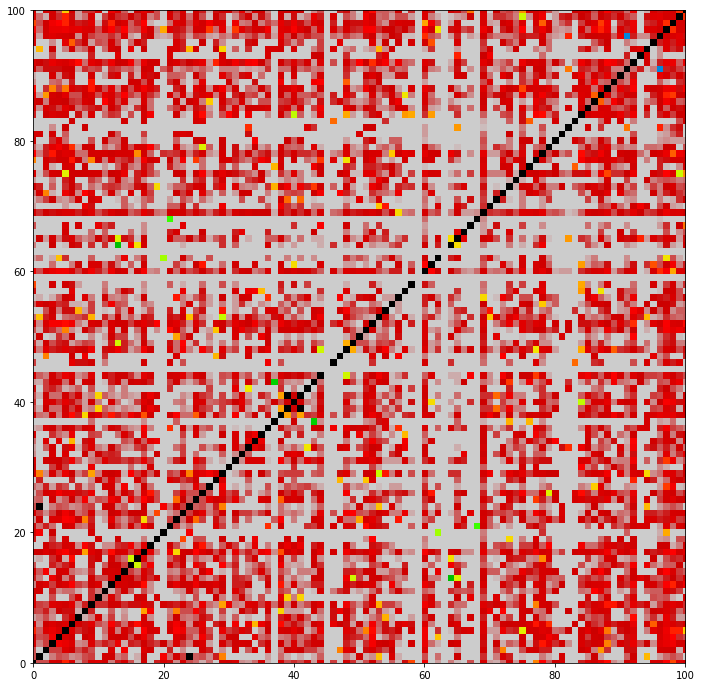

In [23]:
plt.figure(figsize=(12,12))
plt.xlim(0,100)
plt.ylim(0,100)

plt.imshow(XD,cmap='nipy_spectral_r')

**Go for K-Means clustering**

In [24]:
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

In [25]:
true_k = 20

normalize the data 

In [26]:
nn = Normalizer()
XN = nn.fit_transform(XD)

In [27]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,verbose=True)

In [28]:
km.fit(XN)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2916.9811800223983
start iteration
done sorting
end inner loop
Iteration 1, inertia 2816.1499821174584
start iteration
done sorting
end inner loop
Iteration 2, inertia 2776.2874716094707
start iteration
done sorting
end inner loop
Iteration 3, inertia 2758.1559236858106
start iteration
done sorting
end inner loop
Iteration 4, inertia 2746.0893970811003
start iteration
done sorting
end inner loop
Iteration 5, inertia 2738.1594587430354
start iteration
done sorting
end inner loop
Iteration 6, inertia 2733.048895655981
start iteration
done sorting
end inner loop
Iteration 7, inertia 2729.6614142388376
start iteration
done sorting
end inner loop
Iteration 8, inertia 2727.620050676708
start iteration
done sorting
end inner loop
Iteration 9, inertia 2726.5421225778678
start iteration
done sorting
end inner loop
Iteration 10, inertia 2725.4067596333484
start iteration
done sorting
end inner loop
Iteration

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=20, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=True)

append to each cluster the relative cluster

In [29]:
km.labels_

array([ 0,  4, 16, ...,  4,  0,  4], dtype=int32)

get the length of each cluster 

In [30]:
tws = list(corpus) 
clusters = {}
idx = 0
for t in km.labels_:
    if(t in clusters):
        clusters[t].append(tws[idx])
    else:
        clusters[t]= [tws[idx]]
    idx += 1

study the length of the cluster 

In [31]:
for k,v in clusters.items():
    print(k,len(v))

0 988
4 830
16 340
2 282
3 181
5 119
11 535
1 215
13 157
15 142
8 263
9 31
19 92
6 372
7 89
10 167
14 69
17 3
18 102
12 23


**Visualize content of the cluster**

what there is inside 

In [34]:
for c in clusters[17]:
    print(c)
    print("########")

Hey GUI folks,

Does anyone out there have experience with the HP Interface Architect
(GUI dev tool)?  If so, can I call you and ask a couple of quick
questions?  I promise I'll be brief, the questions are simple, and of
course I'll call on my nickel.

Jeff Copeland
jeffcop@i88.isc.com

708-505-9100 x330
INTERACTIVE Systems Corp. (now a Systemhouse co.)
########
Hey GUI folks,

Does anyone out there have experience with the HP Interface Architect
(GUI dev tool)?  If so, can I call you and ask a couple of quick
questions?  I promise I'll be brief, the questions are simple, and of
course I'll call on my nickel.

Jeff Copeland
jeffcop@i88.isc.com

708-505-9100 x330
INTERACTIVE Systems Corp. (now a Systemhouse co.)
########
Hey GUI folks,

Does anyone out there have experience with the HP Interface Architect
(GUI dev tool)?  If so, can I call you and ask a couple of quick
questions?  I promise I'll be brief, the questions are simple, and of
course I'll call on my nickel.

Jeff Copeland
jef

### how to get the optimal number of clusters (for kmeans)? ###

**the Elbow method**

In [35]:
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

In [36]:
scores = []
distortions = []
rng = range(2,40,1) ## study in function of a changing cluster size
for t in rng:
    km = KMeans(n_clusters=t, init='k-means++', max_iter=100, n_init=1,verbose=False)
    km.fit(XD)

    distortions.append( km.inertia_ ) ## the inertia is the squared distance from the centroids
    if(t%10 == 0):
        print(t)

10
20
30


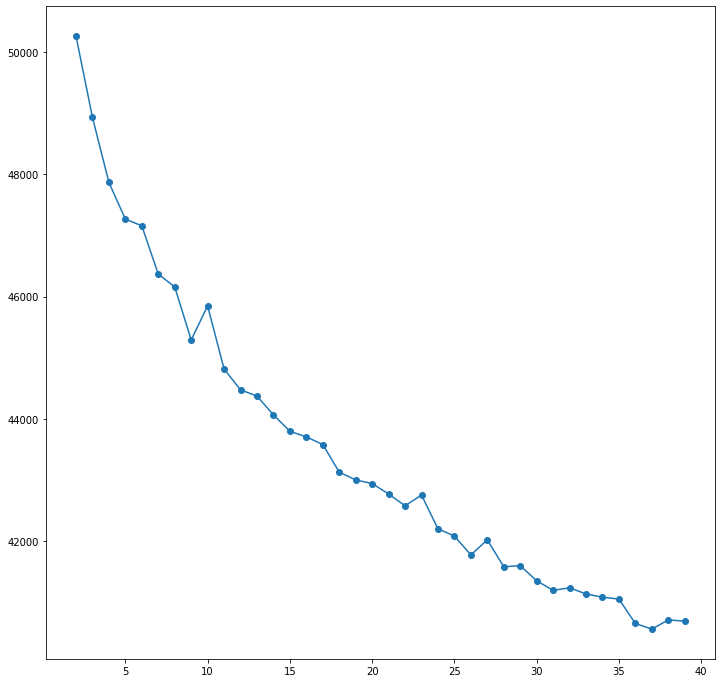

In [37]:
plt.figure(figsize=(12,12))
plt.plot( rng,distortions,marker="o")

**considerations**

Ideally the plot it will show a point where the slope changes, the point where there is a change is the "elbow" and this is the optimal point (if any) 